![banner](../banner.jpg)

***Training course in data analysis for genomic surveillance of African malaria vectors - Workshop 1***

---

# Module 3 - Navigating the *Anopheles gambiae* reference genome

**Theme: Biology**

The following module aims to introduce the reference genome and genome annotations that we use for *Anopheles gambiae*. 

## Learning objectives

By the end of this module you should:

- Understand the structure of the *Anopheles gambiae* reference genome.
- Be able to use genomic coordinates to identify sites and regions within the reference genome.
- Understand what genes are and where genes are located within the reference genome.
- Be familiar with the central dogma of biology, which describes how genes are transcribed into mRNA and translated into proteins.

Please note that the underlying data for the reference genome sequence and the gene annotations are maintained and hosted by [VectorBase](https://vectorbase.org/). We provide access to these resources through the `malariagen_data` Python package purely for convenience, but these data were not generated by MalariaGEN. 

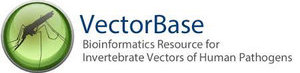</img>

## Lecture

### English

In [1]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/K3NDJvbbjMk" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

### Français

In [2]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/Fn8617mPnq0" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

Please note that the code in the cells below might differ from that shown in the video. This can happen because Python packages and their dependencies change due to updates, necessitating tweaks to the code.

## Setup

First we need to install and import the python packages required for our data analysis.

In [3]:
%pip install -q --no-warn-conflicts malariagen_data

In [3]:
from collections import Counter
import malariagen_data
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import bokeh.io as bkio
bkio.output_notebook()

Loading BokehJS ...

Once the packages are imported, set up data access through the `malariagen_data` package.

In [4]:
ag3 = malariagen_data.Ag3()
ag3

<MalariaGEN Ag3 API client>
Storage URL             : gs://vo_agam_release/
Data releases available : 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8
Results cache           : None
Cohorts analysis        : 20231215
AIM analysis            : 20220528
Site filters analysis   : dt_20200416
Software version        : malariagen_data 8.7.0
Client location         : unknown
---
Please note that data are subject to terms of use,
for more information see https://www.malariagen.net/data
or contact data@malariagen.net. For API documentation see 
https://malariagen.github.io/malariagen-data-python/v8.7.0/Ag3.html

## Structure of the genome

- The genome of an organism is represented by chromosomes, which are sequences of DNA.
- Diploid organisms have two copies of each chromosome, one inherited from each parent. 
- Each chromosome can be divided into two chromosome arms which are separated by the centromere, a constricted region of the chromosome involved in cell division. 

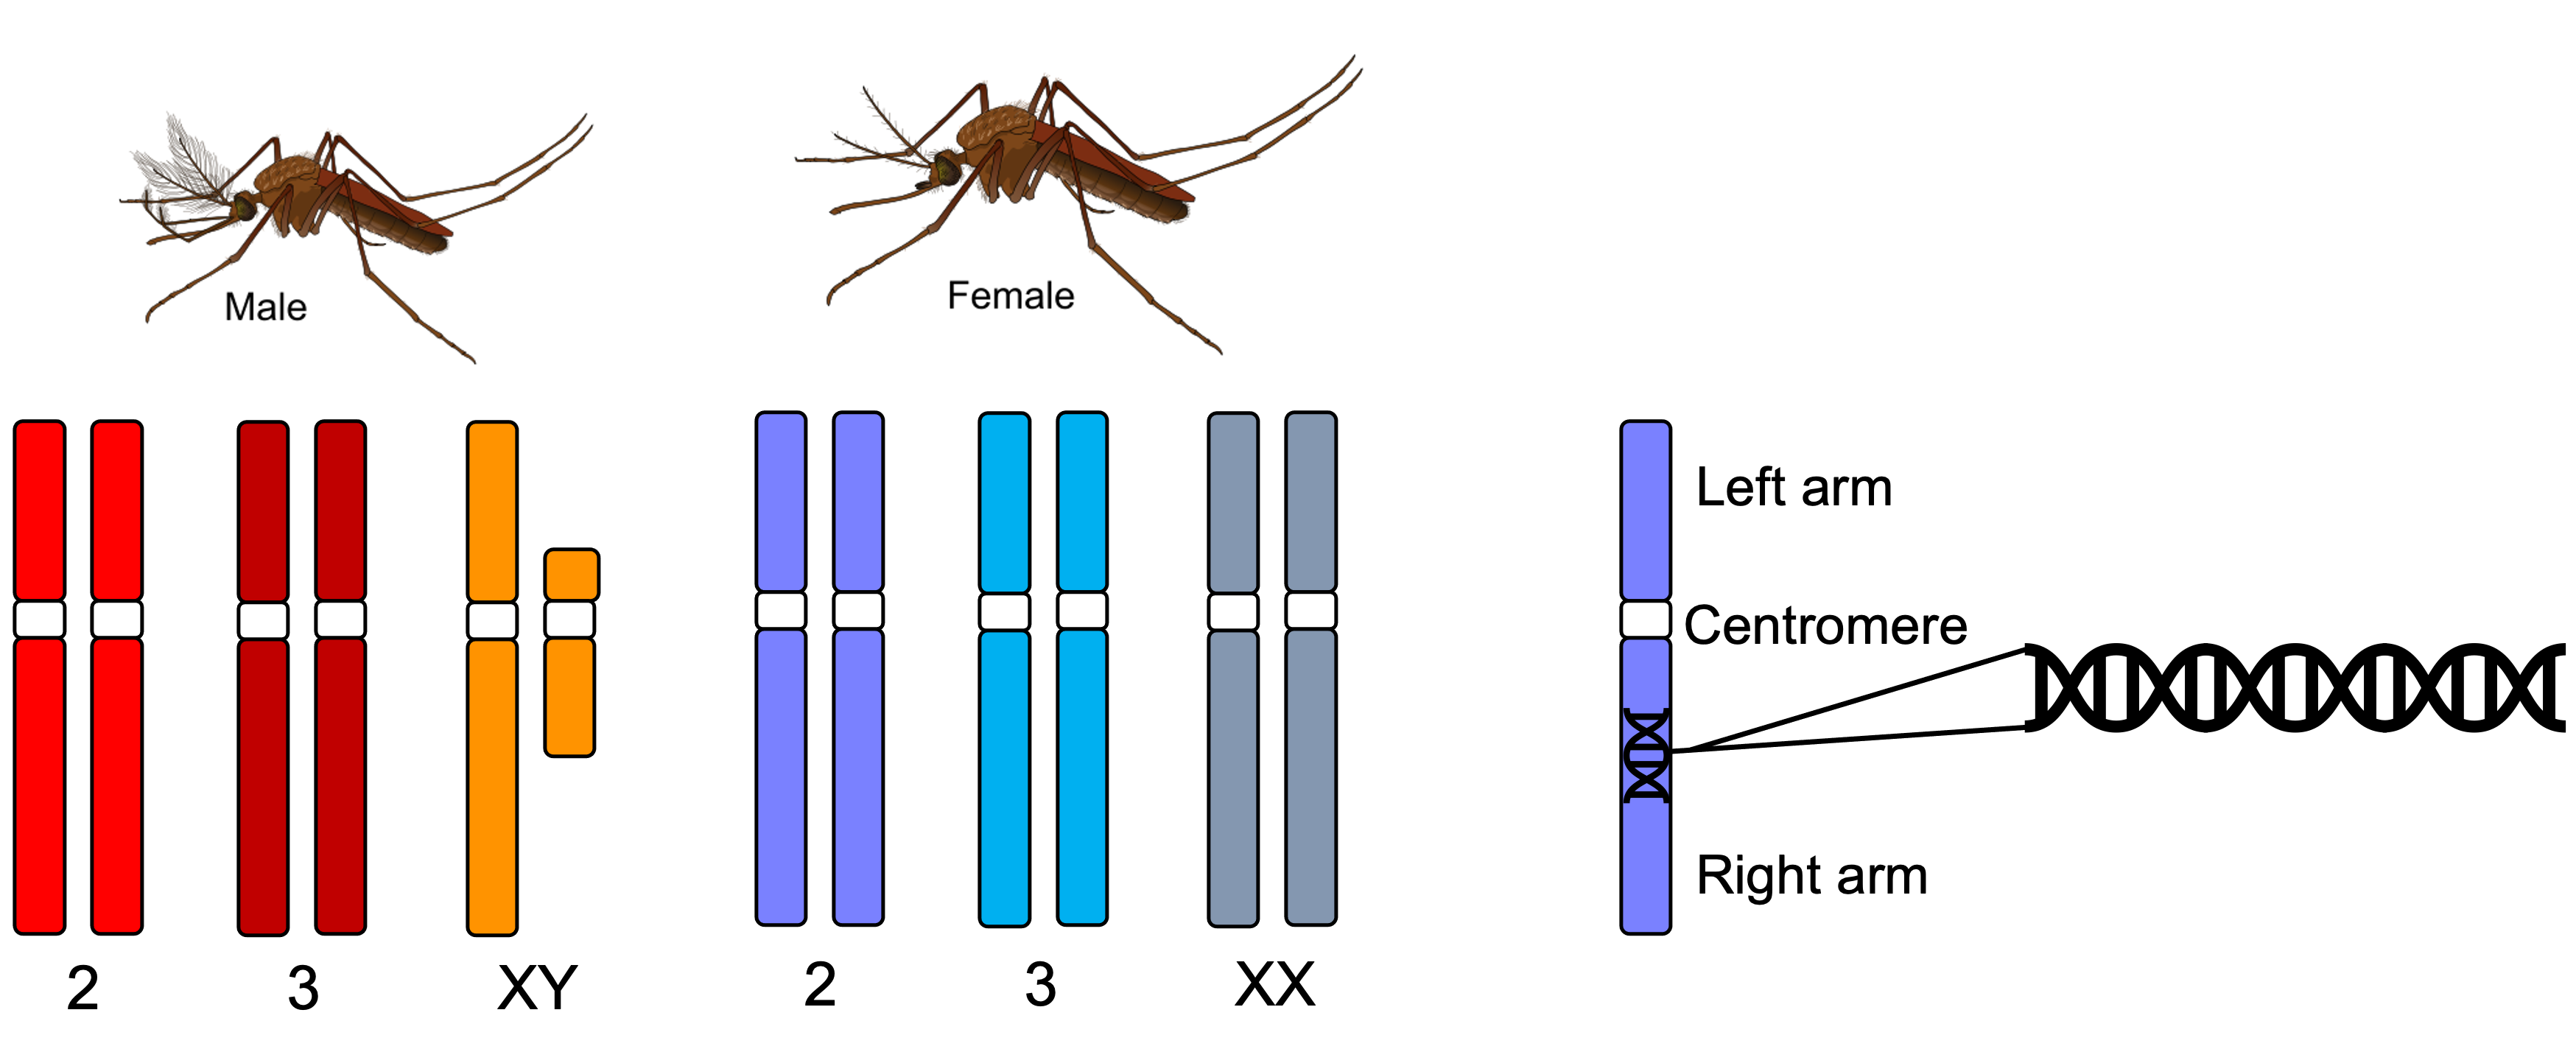</img>

- The *Anopheles gambiae* genome for example is composed of three chromosome pairs each seperated into right (R) and left (L) chromosome arms. 
- Two of these chromosome pairs (chromosomes 2 and 3) are autosomes, i.e. both males and females have two copies. 
- The final chromosome pair, the X and Y chromosomes are those which determine sex, with two copies of the X chromosome found in females and one copy of X and one of Y found in males. 
- You may come across terms such as scaffolds or contigs, these are simply smaller units into which the genome sequence of a chromosome can be broken down.
- The reference genome is hosted by Vectorbase, an open source web-based resource.

## Exploration of the *Anopheles gambiae* reference genome

For *Anopheles gambiae* we currently use the AgamP4 reference genome, also known as PEST. The DNA sequence data for this reference genome are organised and accessed by chromosome arm. Below we can access the 'contigs' to see the chromosome arms avalaible to us. 

In [6]:
ag3.contigs

('2R', '2L', '3R', '3L', 'X')

You will note that the Y chromosome is not listed here. This is because the repetitive nature of the genome on the Y chromosome has prevented reliable genome assembly to date. As a result little is known about its structure or function.

The following code can be used to access a specific chromosome arm of the reference genome and view the first 100 base pairs, i.e., DNA nucleotides represented by either 'A', 'T', 'G' or 'C'.

Because the data are reasonably large, the DNA sequence is returned as a [Dask array](https://docs.dask.org/en/stable/array.html), which allows you to be selective about which data are loaded into memory, and so avoid running out of memory. The `.compute()` call causes data to be loaded into memory.

In [7]:
seq = ag3.genome_sequence("2L").compute()
seq[:100]

array([b'a', b'a', b'c', b'c', b'a', b't', b'g', b'g', b't', b'c', b'c',
       b'a', b'g', b'a', b'g', b't', b'a', b'c', b'a', b'c', b'a', b't',
       b't', b'g', b'a', b'c', b't', b'a', b't', b'g', b'c', b'a', b'g',
       b'g', b'c', b'c', b't', b'a', b'g', b't', b'a', b'g', b'a', b'c',
       b'g', b'a', b'a', b't', b't', b'c', b't', b'a', b'c', b't', b't',
       b'c', b'c', b't', b't', b'g', b't', b'a', b'a', b't', b'c', b'g',
       b't', b'g', b'g', b'a', b't', b'c', b'c', b'a', b'c', b'a', b'c',
       b't', b'c', b'g', b'a', b'a', b'a', b't', b'g', b'g', b'c', b'c',
       b'g', b'g', b'a', b'a', b'g', b't', b't', b't', b'a', b'c', b'g',
       b'c'], dtype='|S1')

To refer to a specific site (position) within a sequence, we typically use 1-based coordinates. E.g., “2L:10” refers to the tenth nucleotide (letter) in the 2L sequence. We can access this nucleotide via Python, but when indexing in Python we need to remember to use zero-based indices. To access the nucleotide at position 10 on chromosome arm 2L:

In [8]:
seq[9]

b'c'

Note that there are also some “gaps” in the reference genome, where we don’t know what the nucleotide is. These are represented in the sequence with the letter "N" or "n". Let’s take a look at how common these are, for chromosome arm 2L:

In [9]:
# The code .most_common() returns a list of counts for the components of a list giving the most common first.
def count_nucleotides(contig):
    seq = ag3.genome_sequence(contig).compute()
    return Counter(seq).most_common()

In [10]:
count_nucleotides("2L")

[(b'T', 11398889),
 (b'A', 11394851),
 (b'C', 9348150),
 (b'G', 9341894),
 (b't', 2086607),
 (b'a', 2078364),
 (b'g', 1444984),
 (b'c', 1432008),
 (b'n', 838575),
 (b'N', 3)]

Here the nucleotide bases are present in both upper and lower case letters. Lower case letters represent bases which have been "soft masked" because the genome is repetitive in that region, but this does not need to be considered in most cases. For our purposes, both “T” and “t” mean the same thing.

We can see that throughout the 2L chromosome arm, there are 838,578 nucleotides which are unknown (either “N” or “n”).

To gain a bit more intuition for how the genome is structured and the relative sizes of the different sequences, use the function below to make a plot of the five chromosome arms, summarising the relative abundance of the different nucleotides. An example is provided.

In [11]:
def plot_sequence_composition(contig, window_size=100_000, ax=None):

    # load reference sequence
    seq = ag3.genome_sequence(contig).compute()

    if ax is None:
        # make the figure size relative to largest contig
        figw = 7 * len(seq) / len(ag3.genome_sequence("2R"))
        fig, ax = plt.subplots(figsize=(figw, 1))

    # convert to upper-case
    seq = np.char.upper(seq)

    # locate nucleotides
    is_a = seq == b"A"
    is_c = seq == b"C"
    is_g = seq == b"G"
    is_t = seq == b"T"
    is_n = seq == b"N"
    # check there's nothing unexpected
    is_other = ~is_a & ~is_c & ~is_g & ~is_t & ~is_n
    assert np.sum(is_other) == 0

    # construct windows
    bins = np.arange(0, len(seq), window_size)

    # count nucleotides in each window
    h_a, _ = np.histogram(np.nonzero(is_a)[0] + 1, bins=bins)
    h_c, _ = np.histogram(np.nonzero(is_c)[0] + 1, bins=bins)
    h_g, _ = np.histogram(np.nonzero(is_g)[0] + 1, bins=bins)
    h_t, _ = np.histogram(np.nonzero(is_t)[0] + 1, bins=bins)
    h_n, _ = np.histogram(np.nonzero(is_n)[0] + 1, bins=bins)

    # plot frequence of nucleotides within each bin
    left = bins[:-1]
    bottom = 0
    width = np.diff(bins)
    palette = sns.color_palette("colorblind")
    colors = [palette[i] for i in [2, 0, 3, 8]] + ["k"]
    for h, c, l in zip([h_a, h_t, h_g, h_c, h_n], colors, "ATGCN"):
        ax.bar(left, h, width=width, bottom=bottom, color=c, align="edge", label=l)
        bottom += h

    # tidy up plot
    ax.set_xlim(0, len(seq))
    ax.set_yticks(ax.get_ylim())
    ax.set_yticklabels(["0%", "100%"])
    ax.set_title(contig)
    # convert X axis to Mbp
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: x // 1e6))
    ax.set_xlabel("Position (Mbp)")

    # add centromere/telomere annotation
    if contig in {"2L", "3L"}:
        ltxt = "centromere"
        rtxt = "telomere"
    else:
        ltxt = "telomeric"
        rtxt = "centromeric"
    ax.annotate(
        ltxt,
        xy=(0, 1),
        xycoords="axes fraction",
        xytext=(0, 2),
        textcoords="offset points",
        va="bottom",
        ha="left",
    )
    ax.annotate(
        rtxt,
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0, 2),
        textcoords="offset points",
        va="bottom",
        ha="right",
    )

    # add legend - reverse order so matches the plot
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles),
        reversed(labels),
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        prop=dict(family="monospace"),
        ncol=1,
        frameon=False,
    )

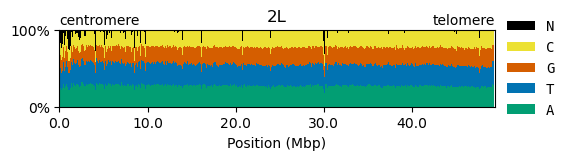

In [12]:
plot_sequence_composition("2L")

A few points to note :

* All of the chromosome arms are made up of A, C, T and G in roughly equal proportion, although A and T are a little more common than C and G.

* We have noted the location of the centromere and also annotated the telomere. We came across the term centromere previously and it may be worth noting here that the genomic composition of the centromere is very different to the rest of the chromosome and as such is subject to different evolutionary forces. The telomere is a region located at the end of chromosomes which is typically composed of many repetitive DNA sequences that do not code for proteins. The function of the telomere is to protect the chromosome from damage. 

* Gaps (N) are relatively uncommon, except towards the centromere of all chromosome arms where they are more common. This is typically because sequences are more repetitive towards the centromeres and so assembling the genome is more difficult.

* We made the size of each figure proportional to the length of the sequence. This was to help give a feeling for the relative size of the different chromosome arms.

* We converted the X-axis coordinates to “Mbp” which means mega-base pairs, i.e., millions of letters.


## Accessing the reference genome annotations

- The genome sequence of each chromosome can be split into regions that do and do not represent genes that are transcribed and translated into functional proteins, i.e., coding and non-coding DNA respectively. 
- Gene annotations provide information on which regions of the genome encode genes. 

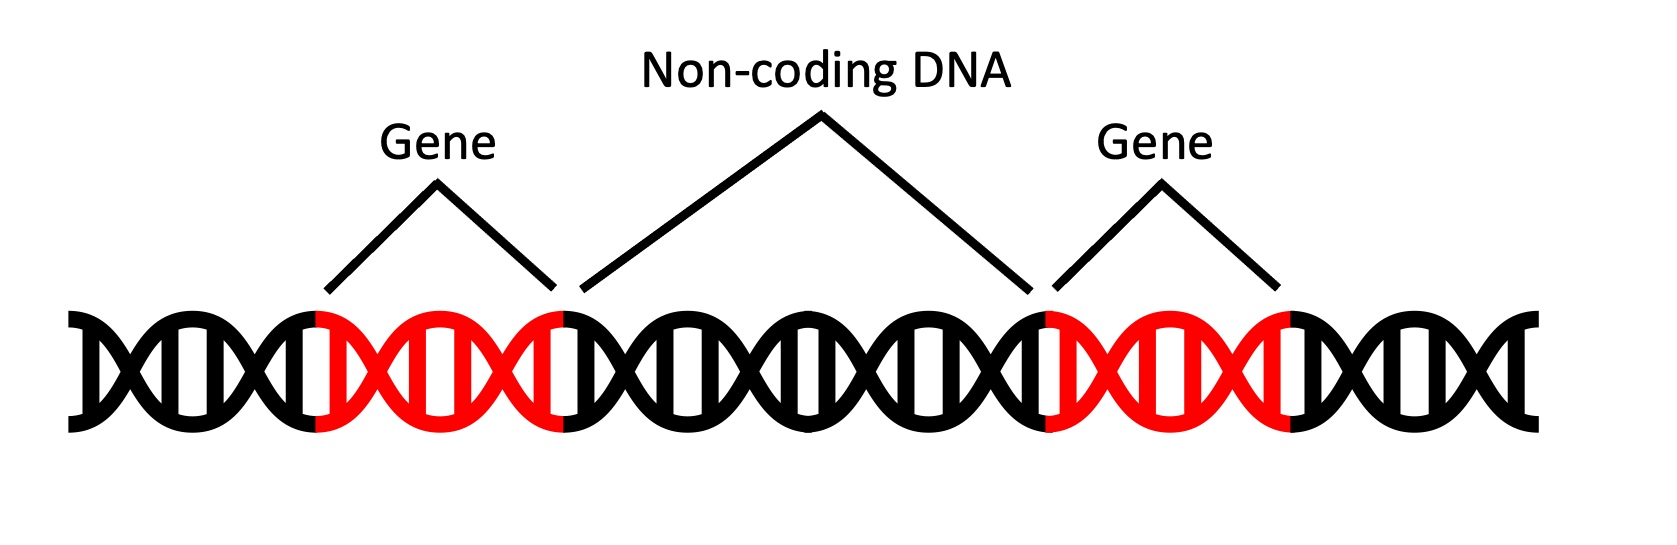</img>

**Figure 2.** Coding and non-coding DNA.

We can access the annotation of the reference genome as a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/user_guide/dsintro.html) using the following code.

In [13]:
df_geneset = ag3.geneset().set_index("ID")
df_geneset

contig      source             type   start       end  \
ID                                                                         
2L                     2L  VectorBase       chromosome       1  49364325   
AGAP004677             2L  VectorBase             gene  157348    186936   
AGAP004677-RA          2L  VectorBase             mRNA  157348    181305   
NaN                    2L  VectorBase  three_prime_UTR  157348    157495   
NaN                    2L  VectorBase             exon  157348    157623   
...                   ...         ...              ...     ...       ...   
NaN            Y_unplaced  VectorBase   five_prime_UTR   47932     48111   
NaN            Y_unplaced  VectorBase             exon   47932     48138   
AGAP029375-PA  Y_unplaced  VectorBase              CDS   48112     48138   
NaN            Y_unplaced  VectorBase             exon   48301     48385   
AGAP029375-PA  Y_unplaced  VectorBase              CDS   48301     48385   

               score strand  phase         Parent              Name  \
ID                                                                    
2L               NaN    NaN    NaN            NaN               NaN   
AGAP004677       NaN      -    NaN            NaN               NaN   
AGAP004677-RA    NaN      -    NaN     AGAP004677               NaN   
NaN              NaN      -    NaN  AGAP004677-RA               NaN   
NaN              NaN      -    NaN  AGAP004677-RA  AGAP004677-RB-E4   
...              ...    ...    ...            ...               ...   
NaN              NaN      +    NaN  AGAP029375-RA               NaN   
NaN              NaN      +    NaN  AGAP029375-RA  AGAP029375-RA-E2   
AGAP029375-PA    NaN      +    0.0  AGAP029375-RA               NaN   
NaN              NaN      +    NaN  AGAP029375-RA  AGAP029375-RA-E3   
AGAP029375-PA    NaN      +    0.0  AGAP029375-RA               NaN   

                                                     description  
ID                                                                
2L                                                           NaN  
AGAP004677     methylenetetrahydrofolate dehydrogenase(NAD ) ...  
AGAP004677-RA                                                NaN  
NaN                                                          NaN  
NaN                                                          NaN  
...                                                          ...  
NaN                                                          NaN  
NaN                                                          NaN  
AGAP029375-PA                                                NaN  
NaN                                                          NaN  
AGAP029375-PA                                                NaN  

[196145 rows x 11 columns]

Each row of this data frame is a “feature”, which is a general term meaning some kind of annotation on the reference genome. The type column tells us what kind of feature and the seqid. Start and end columns tell us where the feature is located within the reference genome sequence. The strand column tells us whether this feature is read using the forward (“+”) or reverse (“-”) strand of the DNA sequence.

For example, the second row is a “gene” feature, which occurs on chromosome arm 2L, starting at position 157,348 and ending at position 186,936. The identifier for this gene is “AGAP004677”. This gene hasn’t been given a name, but does have a description, which may tell us something about the function of the protein that this gene encodes (in this case, a methylenetetrahydrofolate dehydrogenase).

## Introducing the voltage-gated sodium channel gene

- One particular gene of interest is the voltage-gated sodium channel (*Vgsc*), also known as *para*, which encodes for a protein called VGSC which is the binding target of pyrethroid insecticides. 
- Pyrethroids function by binding to the associated protein and disrupting normal nervous system functions. 
- Changes to the nucleotide sequence of the *Vgsc* gene can alter the structure or function of proteins and prevent the 'knock-down' of the mosquito. As a result, an increased dose of insectide treatment may be required to cause death. 
- This is an example of how a change to a genotype can impact on phenotype.

Several nucleotide changes in the *Vgsc* gene have been implicated in an increased resistance to insecticides in *Anopheles* mosquitoes. These include the substitutions L995S found in Central and East Africa and the substitutions L995F and N1570Y which are present in Central and West Africa and often found together.

The figure below shows the nucleotide changes that have been identified in the *Vgsc* and where in the protein these changes impact on structure.

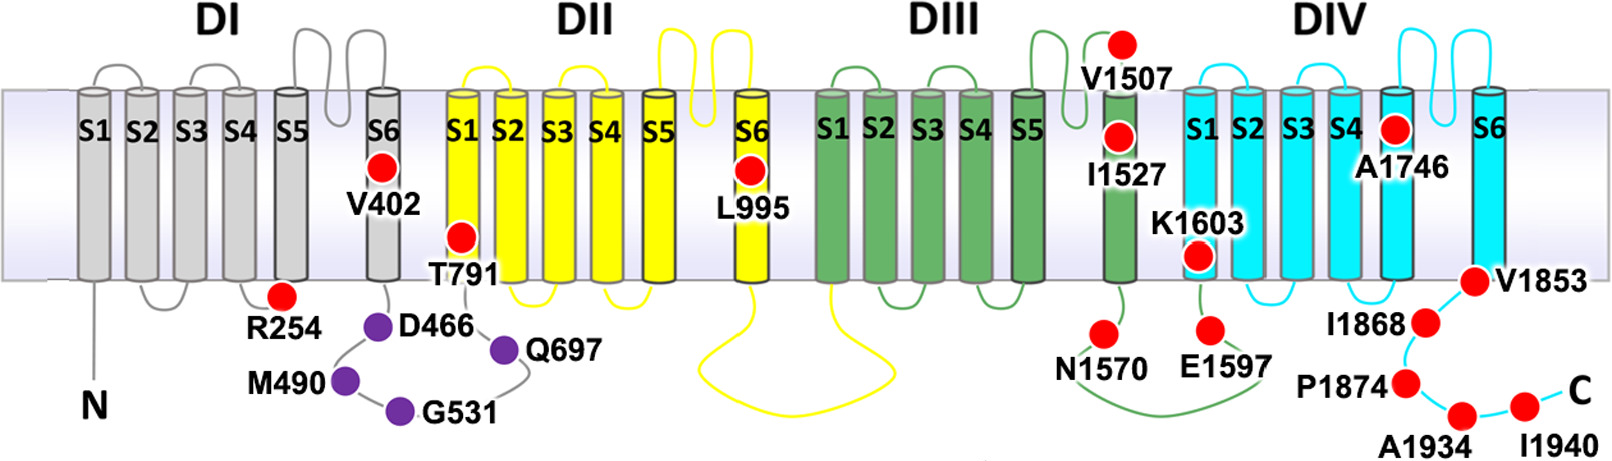</img>

**Figure 3.** Voltage-gated sodium channel protein structure and non-synonymous variation. The VGSC protein is shown as a transmembrane topology map in cartoon format coloured by domain. Variant positions are shown as red circles in the topology map. Purple circles in the map show amino acid substitutions that couldn't be modelled in [Clarkson *et al.* (2021)](https://onlinelibrary.wiley.com/doi/full/10.1111/mec.15845).

We can take a look at the annotation for the voltage-gated sodium channel gene using its identifer "AGAP004707". 

In [14]:
df_geneset.loc["AGAP004707"]

contig                                                        2L
source                                                VectorBase
type                                                        gene
start                                                    2358158
end                                                      2431617
score                                                        NaN
strand                                                         +
phase                                                        NaN
Parent                                                       NaN
Name                                                        para
description    voltage-gated sodium channel [Source:VB Commun...
Name: AGAP004707, dtype: object

From the annotation, we can see that the gene is located on chromosome 2L and starts at position 2,358,158.

We can visualise how genes are organised across the chromosome arm on which the voltage-gated sodium channel is found using the following plotting function.

In [18]:
ag3.plot_genes("2L")

When zoomed out to an entire chromosome arm like in the plot above, it is hard to see the individual genes. However, you can zoom in to any region by using the mouse wheel or the tool icons at the top right of the plot. If you hover over a gene, you’ll hopefully see its ID, as well as its name and description if it has them. If you click on a gene, you’ll be taken to the corresponding gene page on VectorBase, the web-based resource that maintains the reference genome.

## Transcription

- Genes are transcribed into mRNA, which means that the DNA sequence from the gene region is “read” and used as a template to build an mRNA molecule with an equivalent nucleotide sequence. mRNA forms the template from which a protein's amino acids are formed. 

- For many genes, the process of transcription is followed by splicing, which means that parts of the sequence are cut out before the mRNA is translated into protein. The parts of the gene sequence that are cut out are called “introns”. The parts of the gene sequence that are kept and included in the final mRNA molecule are called “exons”. 

- Often there are alternative ways in which a gene sequence can be read during transcription. For example, each transcript may include different exons, or exons may vary in length. Alternative splicing can allow the same gene to encode different proteins, which may perform different functions. 

- A change to the DNA sequence of a gene encoding for different transcripts has the potential to impact on protein function more than once, with the outcome dependent on the transcript under investigation.

- Mostly the exons comprise DNA sequence that is translated into an amino acid sequence, and these protein-coding segments are called “CDSs”, which stands for coding sequences. 

- Some genes also include “UTRs” which are untranslated regions at the start and end of the gene sequence. These UTRs are included in the exons but do not get translated into protein. A UTR at the start of the gene is called a “five prime UTR” and a UTR at the end of a gene is called a “three prime UTR”.





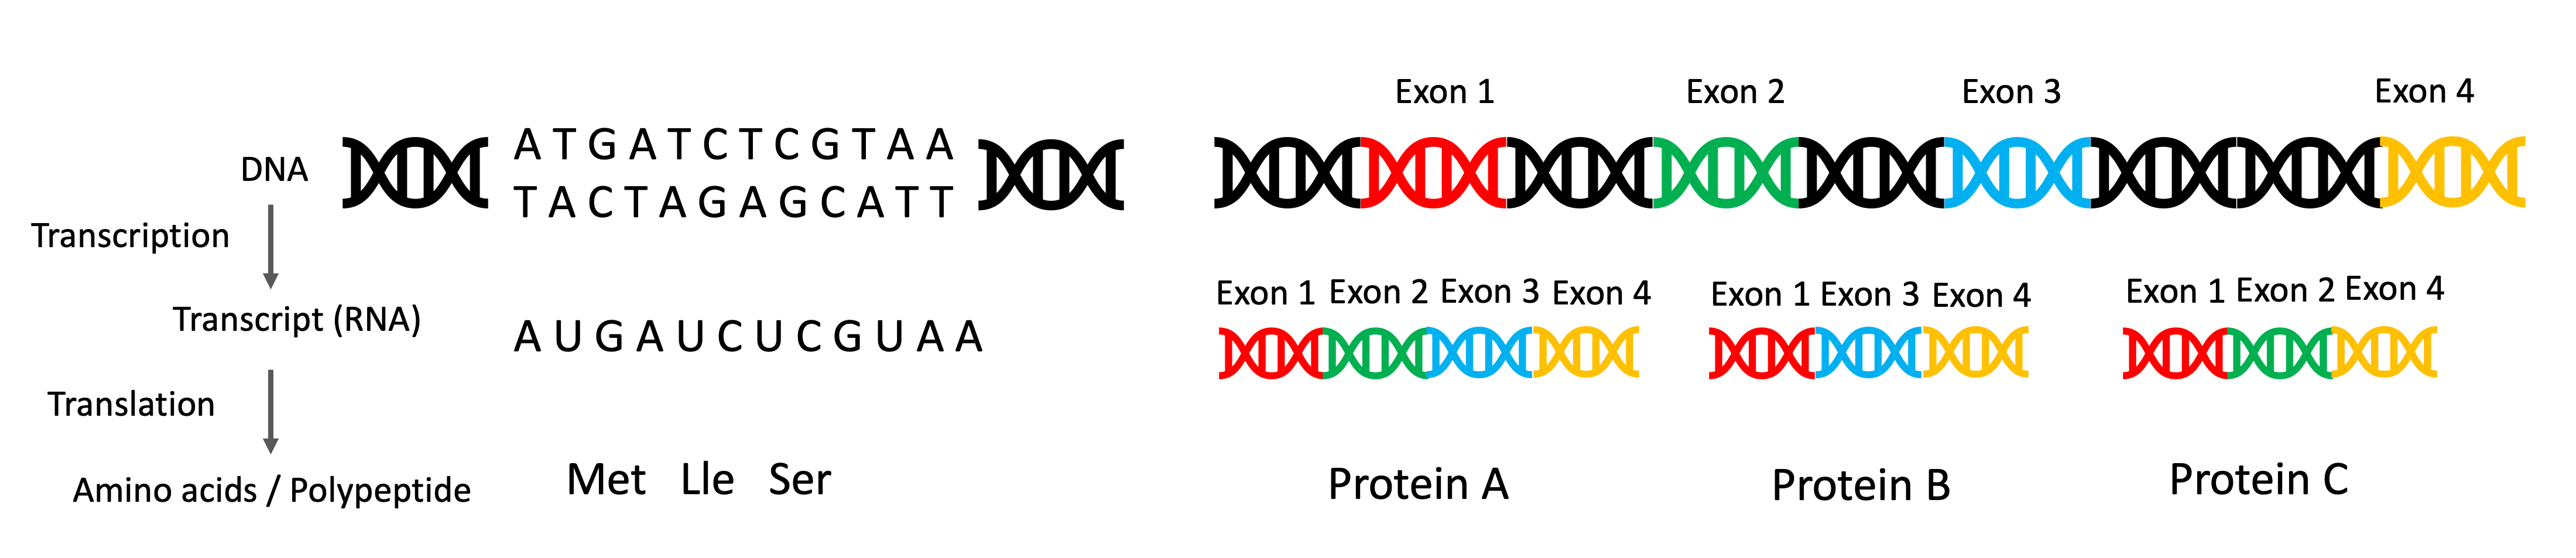</img>

**Figure 4.** The process of transcription, translation and the alternative splicing of genes.

## Accessing the transcripts of a gene

The different known transcripts of any given gene are annotated in the reference genome and can be accessed using the name of the gene you are interested in. We can view the transcripts available for the voltage-gated sodium channel using it's gene identifier.

The table of gene annotations is a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/user_guide/dsintro.html#dataframe), which means we can find the transcripts by using the [`query()` method](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#the-query-method).

In [19]:
df_geneset.query("Parent == 'AGAP004707'")

contig      source  type    start      end  score strand  phase  \
ID                                                                              
AGAP004707-RA     2L  VectorBase  mRNA  2358158  2431617    NaN      +    NaN   
AGAP004707-RB     2L  VectorBase  mRNA  2358158  2431617    NaN      +    NaN   
AGAP004707-RC     2L  VectorBase  mRNA  2358158  2431617    NaN      +    NaN   
AGAP004707-RD     2L  VectorBase  mRNA  2358158  2431617    NaN      +    NaN   
AGAP004707-RE     2L  VectorBase  mRNA  2358158  2431617    NaN      +    NaN   
AGAP004707-RF     2L  VectorBase  mRNA  2358158  2431617    NaN      +    NaN   
AGAP004707-RG     2L  VectorBase  mRNA  2358158  2431617    NaN      +    NaN   
AGAP004707-RH     2L  VectorBase  mRNA  2358158  2431617    NaN      +    NaN   
AGAP004707-RI     2L  VectorBase  mRNA  2358158  2431617    NaN      +    NaN   
AGAP004707-RJ     2L  VectorBase  mRNA  2358158  2431617    NaN      +    NaN   
AGAP004707-RK     2L  VectorBase  mRNA  2358158  2431617    NaN      +    NaN   
AGAP004707-RL     2L  VectorBase  mRNA  2358158  2431617    NaN      +    NaN   
AGAP004707-RM     2L  VectorBase  mRNA  2358158  2431617    NaN      +    NaN   

                   Parent Name description  
ID                                          
AGAP004707-RA  AGAP004707  NaN         NaN  
AGAP004707-RB  AGAP004707  NaN         NaN  
AGAP004707-RC  AGAP004707  NaN         NaN  
AGAP004707-RD  AGAP004707  NaN         NaN  
AGAP004707-RE  AGAP004707  NaN         NaN  
AGAP004707-RF  AGAP004707  NaN         NaN  
AGAP004707-RG  AGAP004707  NaN         NaN  
AGAP004707-RH  AGAP004707  NaN         NaN  
AGAP004707-RI  AGAP004707  NaN         NaN  
AGAP004707-RJ  AGAP004707  NaN         NaN  
AGAP004707-RK  AGAP004707  NaN         NaN  
AGAP004707-RL  AGAP004707  NaN         NaN  
AGAP004707-RM  AGAP004707  NaN         NaN

We can see here that there are thirteen possible transcripts, each with type “mRNA”. This means there are up to thirteen possible ways in which a single nucleotide change to the reference sequence of the VGSC gene could impact on protein function.

We can visualise the structure of a given transcript using the `plot_transcript()` function. 

In [20]:
ag3.plot_transcript("AGAP004707-RA");

In [21]:
ag3.plot_transcript("AGAP004707-RD");

In [22]:
ag3.plot_transcript("AGAP004707-RG");

The boxes are exons and the connecting lines are introns. CDSs are coloured in blue. If the gene had untranslated regions then five prime UTRs would be coloured in green, and three prime UTRs coloured in red. However, not all genes have these, and this is the case for *Vgsc*.

You may observe that transcript AGAP004707-RD has an additional exon compared to AGAP004707-RA, whereas AGAP004707-RG has an exon missing. If a nucleotide change was to occur in the gene sequence impacting this exon, the alternative transcripts would be differentially impacted. You will learn more about how changes to the genomic sequence encoding genes impact on transcription in the following module, Analysing SNPs in the *Vgsc* gene.

## Well done!

In this module you have learnt how to access the reference genome and the annotations which support it and we have introduced the idea that genomic variation can impact on protein function. In the upcoming module 'Analysing SNPs in the VGSC gene', you will learn how to use the reference genome together with the genomic data avaliable from wild populations to explore the impact of these genome changes.

## Practical exercises

### English

1. [Open this notebook in Google Colab](https://colab.research.google.com/github/anopheles-genomic-surveillance/anopheles-genomic-surveillance.github.io/blob/master/docs/workshop-1/module-3-genome.ipynb) and run it for yourself from top to bottom. Hint: click the rocket icon (<i class="fas fa-rocket"></i>) at the top of the page, then select “Colab” from the drop-down menu. When colab opens, click the "Edit" menu, then select "Clear all outputs", then begin running the cells. 
1. Modify the notebook to print the first 200 nucleotides of chromosome arm 3R.
1. Count how many adenine ("A" or "a") bases are present on chromosome arm 3R.
1. Make sequence composition plots for all five chromosome arms (2R, 2L, 3R, 3L, X).
1. Find how long each of the chromosome arms are in total. Hint: use the build-in Python `len()` function.
1. Count how many genes are present in the genome annotations. Hint: use a pandas query.
1. Count how many genes are present on each of the five chromosome arms.
1. Using the interactive plot of all genes on chromosome arm 2L, zoom in to find the *Vgsc* gene, then click through to view the gene annotation information on VectorBase. Hint: use the start and end coordinates to find the gene.
1. How long is the *Vgsc* gene? Hint: subtract the start coordinate from the end coordinate.
1. The *VGSC* substitution L995S is caused by a mutation at genome position 2,422,651; L995F at position 2,422,652; and N1570Y at 2,429,745. What nucleotide is present at these positions in the reference genome? Hint: convert the positions to zero-based indices.
1. Make a plot of transcript AGAP004707-RB. What is the difference between this transcript and AGAP004707-RA?
1. If you would like a challenge, investigate the transcripts of another gene of interest. An example could be the the GABA-gated chloride channel subunit that confers resistance to dieldrin, also known as the (*Rdl*) gene. See if you can use vectorbase to search for this gene and find the gene identifer for analysis, then use the functions in this notebook to find out many transcripts it has, and plot them.


### Français

1. [Ouvrir ce notebook dans Google Colab](https://colab.research.google.com/github/anopheles-genomic-surveillance/anopheles-genomic-surveillance.github.io/blob/master/docs/workshop-1/module-3-genome.ipynb) et exécuter le vous-même du début à la fin. Indice: cliquer sur l'icone fusée (<i class="fas fa-rocket"></i>) au sommet de la page et sélectionner "Colab" dans le menu déroulant.
1. Modifier le notebook afin d'afficher les 200 premier nucléotides du bras de chromosome 3R.
1. Compter le nombre de bases adenine ("A" ou "a") se trouvent sur le bras de chromosome 3R.
1. Afficher les graphes de composition des séquences pour tous les bras de chromosome (2R, 2L, 3R, 3L, X).
1. Déterminer la longueur totale de chaque bras de chromosome. Indice: utiliser la fonction python de base `len()`.
1. Compter le nombre de gènes présents parmi les annotations du génome. Indice: utiliser une requête pandas.
1. Compter le nombre de gènes présents sur chacun des cinq bras de chromosome.
1. En utilisant le graphe interactif de tous les gènes du bras de chromosome 2L, zoomer pour trouver le gène *Vgsc*, cliquer ensuite dessus pour voir les informations de son annotation sur VectorBase. Indice: utiliser les coordonnées de début et fin pour trouver le gène.
1. Quelle est la longueur du gène Vgsc? Indice: soustraire la coordonnée de début de celle de fin.
1. La substitution VGSC L995S est causée par une mutation à la position du génome 2,422,651, L995F à la position 2,422,652 et N1570Y à la position 2,429,745. Quelles nucléotides se trouvent à ces positions dans le génome de référence? Indice: convertir les positions en indices commençant à zéro.
1. Créer un graphe de la transcription AGAP004707-RB. Quelle sont les différences entre cette transcription et AGAP004707-RA?
1. Si vous souhaitez un défi, analyser les transcriptions d'un autre gène intéressant. Un exemple est le canal GABA-dépendant chloridique qui confère un résistance au dieldrin, aussi connu sous le nom de gène *Rdl*. Essayer d'utiliser VectorBase pour trouver l'identifiant de ce gène et utiliser les fonctions de ce notebook pour trouver combien de transcriptions existent et en produire un graphe.